# Model subclassing and custom training loops

> In the section, we're going to look at ways to build fully customizable deep learning models and layers, as well as custom training loops. This is the summary of lecture "Customizing your model with Tensorflow 2" from Coursera.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Deep_Learning, Tensorflow]
- image: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

plt.rcParams['figure.figsize'] = (16, 10)
print('Tensorflow: v' + tf.__version__)

Tensorflow: v2.3.1


## Model subclassing

### Example

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

class MyModel(Model):
    def __init__(self, **kwargs):
        super(MyModel, self).__init__(**kwargs)
        self.dense = Dense(16)
        
    def call(self, inputs):
        return self.dense(inputs)
    
my_model = MyModel(name='my_model')

In [3]:
class MyModel(Model):
    def __init__(self, num_classes, **kwargs):
        super(MyModel, self).__init__(**kwargs)
        self.dense1 = Dense(16, activation='sigmoid')
        self.dense2 = Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        h = self.dense1(inputs)
        return self.dense2(h)
    
my_model = MyModel(10, name='my_model')

In [4]:
from tensorflow.keras.layers import Dropout

class MyModel(Model):
    def __init__(self, num_classes, **kwargs):
        super(MyModel, self).__init__(**kwargs)
        self.dense1 = Dense(16, activation='sigmoid')
        self.dropout = Dropout(0.5)
        self.dense2 = Dense(num_classes, activation='softmax')
        
    def call(self, inputs, training=False):
        h = self.dense1(inputs)
        h = self.dropout(h, training=training)
        return self.dense2(h)
    
my_model = MyModel(12, name='my_model')

### Coding Tutorial

#### Create a simple model using the model subclassing API

In [5]:
from tensorflow.keras.layers import Softmax, concatenate

# Build the model
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense_1 = Dense(64, activation='relu')
        self.dense_2 = Dense(10)
        self.dense_3 = Dense(5)
        self.softmax = Softmax()
        
    def call(self, inputs):
        x = self.dense_1(inputs)
        y1 = self.dense_2(inputs)
        y2 = self.dense_3(y1)
        concat = concatenate([x, y2])
        return self.softmax(concat)

In [6]:
# Print the model summary
model = MyModel()
model(tf.random.uniform([1, 10]))
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              multiple                  704       
_________________________________________________________________
dense_6 (Dense)              multiple                  110       
_________________________________________________________________
dense_7 (Dense)              multiple                  55        
_________________________________________________________________
softmax (Softmax)            multiple                  0         
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________


## Custom layers

### Example

In [7]:
from tensorflow.keras.layers import Layer

class LinearMap(Layer):
    def __init__(self, input_dim, units):
        super(LinearMap, self).__init__()
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(initial_value=w_init(shape=(input_dim, units)))
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w)

In [8]:
linear_layer = LinearMap(3, 2)
inputs = tf.ones((1, 3))
linear_layer(inputs)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.13154064,  0.14464289]], dtype=float32)>

In [9]:
linear_layer.weights

[<tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
 array([[-0.08358198,  0.01858256],
        [ 0.00805996,  0.10795677],
        [-0.05601863,  0.01810357]], dtype=float32)>]

Or

In [10]:
class LinearMap(Layer):
    def __init__(self, input_dim, units):
        super(LinearMap, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal')
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w)

In [11]:
class MyModel(Model):
    def __init__(self, hidden_units, outputs, **kwargs):
        super(MyModel, self).__init__(**kwargs)
        self.dense = Dense(hidden_units, activation='sigmoid')
        self.linear = LinearMap(hidden_units, outputs)
        
    def call(self, inputs):
        h = self.dense(inputs)
        return self.linear(h)
    
my_model = MyModel(64, 12, name='my_custom_model')

### Coding Tutorial

#### Create custom layers

In [12]:
class MyLayer(Layer):
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal')
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros')
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
dense_layer = MyLayer(3, 5)
x = tf.ones((1, 5))

In [13]:
dense_layer(x)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.01287571, 0.05181859, 0.03777028]], dtype=float32)>

In [14]:
dense_layer.weights

[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
 array([[ 0.01299221, -0.06098207,  0.05607808],
        [-0.03225943, -0.01771073,  0.00998432],
        [-0.03099572,  0.04720604,  0.00623957],
        [ 0.08610137,  0.05655754, -0.07421251],
        [-0.02296271,  0.02674781,  0.03968081]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

In [15]:
# Specify trainable weights
class MyLayer(Layer):
    def __init__(self, units, input_dim, trainable=True):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal',
                                 trainable=trainable)
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros',
                                 trainable=trainable)
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
dense_layer = MyLayer(3, 5, False)

In [16]:
print('trainable weights: ', len(dense_layer.trainable_weights))
print('non-trainable weights: ', len(dense_layer.non_trainable_weights))

trainable weights:  0
non-trainable weights:  2


In [17]:
# Create a custom layer to accumulate means of output values
class MyLayerMean(Layer):
    def __init__(self, units, input_dim):
        super(MyLayerMean, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal')
        self.b = self.add_weight(shape=(units, ),
                                 initializer='zeros')
        self.sum_activation = tf.Variable(initial_value=tf.zeros((units, )),
                                          trainable=False)
        self.number_call = tf.Variable(initial_value=0, trainable=False)
        
    def call(self, inputs):
        activations = tf.matmul(inputs, self.w) + self.b
        self.sum_activation.assign_add(tf.reduce_sum(activations, axis=0))
        self.number_call.assign_add(inputs.shape[0])
        return activations, self.sum_activation / tf.cast(self.number_call, tf.float32)
    
dense_layer = MyLayerMean(3, 5)

In [18]:
y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means)

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means)

tf.Tensor([ 0.03351649 -0.11652843  0.04783446], shape=(3,), dtype=float32)
tf.Tensor([ 0.03351649 -0.11652843  0.04783446], shape=(3,), dtype=float32)


In [19]:
# Create a Dropout layer as a custom layer
class MyDropout(Layer):
    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        return tf.nn.dropout(inputs, rate=self.rate)

#### Implement the custom layers into a model

In [20]:
class MyModel(Model):
    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()
        
    def call(self, inputs):
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)

In [21]:
model = MyModel(64, 10000, 64, 46)
model(tf.ones((1, 10000)))

<tf.Tensor: shape=(1, 46), dtype=float32, numpy=
array([[0.04749461, 0.0129902 , 0.02068885, 0.02848068, 0.05552515,
        0.09300158, 0.00935825, 0.00225375, 0.03781042, 0.00451264,
        0.12630779, 0.01227046, 0.01431969, 0.00842943, 0.00126452,
        0.00645952, 0.01266537, 0.00493656, 0.02303323, 0.00660236,
        0.02455252, 0.0039958 , 0.01692115, 0.06103001, 0.00990681,
        0.00736192, 0.00882047, 0.01771174, 0.00564999, 0.01150204,
        0.02416532, 0.063745  , 0.00438471, 0.0058762 , 0.05572766,
        0.00755914, 0.01855095, 0.00134857, 0.00652165, 0.0333464 ,
        0.01779144, 0.01062954, 0.01894175, 0.01143594, 0.01280271,
        0.01131547]], dtype=float32)>

In [22]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_2 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout (MyDropout)       multiple                  0         
_________________________________________________________________
my_layer_3 (MyLayer)         multiple                  4160      
_________________________________________________________________
my_dropout_1 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_4 (MyLayer)         multiple                  2990      
_________________________________________________________________
softmax_1 (Softmax)          multiple                  0         
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
__________________________________________________

## Automatic differentiation

### Example

In [23]:
x = tf.constant(2.0)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = x ** 2
    grad = tape.gradient(y, x)

In [24]:
grad

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

In [25]:
x = tf.constant([0, 1, 2, 3], dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.reduce_mean(x ** 2)
    z = tf.math.sin(y)
    dz_dy = tape.gradient(z, y)
    
dz_dy

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9364567>

In [26]:
x = tf.constant([0, 1, 2, 3], dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.reduce_mean(x ** 2)
    z = tf.math.sin(y)
    dz_dy, dz_dx = tape.gradient(z, [y, x])
    
dz_dy

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9364567>

In [27]:
dz_dx

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.        , -0.46822834, -0.9364567 , -1.404685  ], dtype=float32)>

### Coding tutorial

#### Create synthetic data

In [28]:
# Create data from a noise contaminated linear model
def makeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n, ))
    noise = tf.random.normal(shape=(len(x), ), stddev=0.1)
    y = m * x + b + noise
    return x, y

X_train, y_train = makeNoisyData(1, 2)

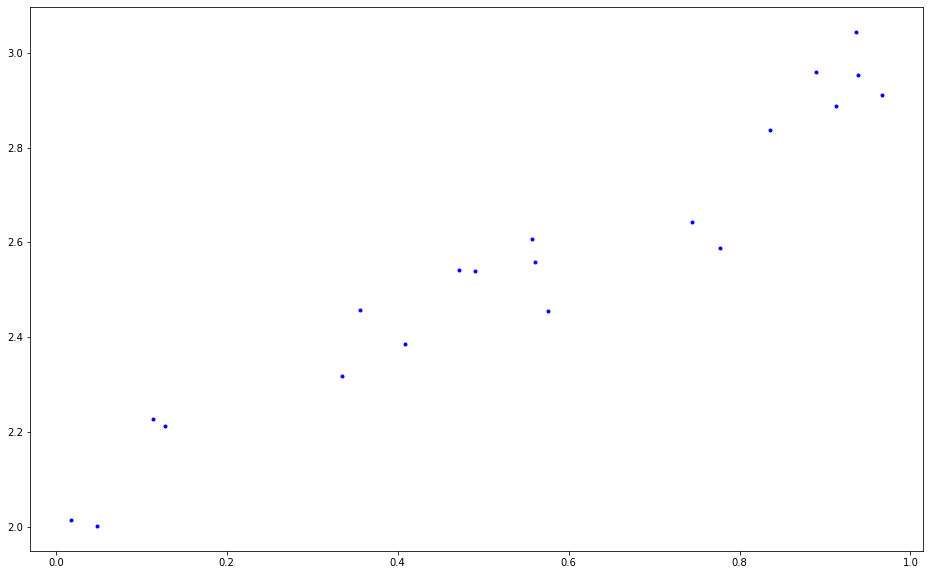

In [29]:
plt.plot(X_train, y_train, 'b.')
plt.show()

#### Define a linear regression model

In [30]:
# Build a custom layer for the linear regression model
class LinearLayer(Layer):
    def __init__(self):
        super(LinearLayer, self).__init__()
        self.m = self.add_weight(shape=(1, ), initializer='random_normal')
        self.b = self.add_weight(shape=(1, ), initializer='zeros')
        
    def call(self, inputs):
        return self.m * inputs + self.b
    
linear_regression = LinearLayer()

In [31]:
linear_regression(X_train)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0.02677927, 0.0499103 , 0.00694781, 0.05119975, 0.02231988,
       0.01827421, 0.00265527, 0.00623694, 0.04860107, 0.04246897,
       0.0194382 , 0.05286601, 0.0456609 , 0.05133465, 0.04065799,
       0.03048198, 0.0257859 , 0.0314845 , 0.03064565, 0.0009532 ],
      dtype=float32)>

In [32]:
linear_regression.weights

[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.05466037], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

#### Define the loss function

In [33]:
def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))

starting_loss = SquaredError(linear_regression(X_train), y_train)
print('Starting loss', starting_loss.numpy())

Starting loss 6.466035


#### Train and plot the model

In [34]:
learning_rate = 0.05
steps = 25

for i in range(steps):
    with tf.GradientTape() as tape:
        predictions = linear_regression(X_train)
        loss = SquaredError(predictions, y_train)
        
    gradients = tape.gradient(loss, linear_regression.trainable_variables)
    
    linear_regression.m.assign_sub(learning_rate * gradients[0])
    linear_regression.b.assign_sub(learning_rate * gradients[1])
    
    print('Step {}, Loss {:.4f}'.format(i, loss.numpy()))

Step 0, Loss 6.4660
Step 1, Loss 4.8636
Step 2, Loss 3.6590
Step 3, Loss 2.7534
Step 4, Loss 2.0726
Step 5, Loss 1.5607
Step 6, Loss 1.1760
Step 7, Loss 0.8867
Step 8, Loss 0.6692
Step 9, Loss 0.5057
Step 10, Loss 0.3828
Step 11, Loss 0.2904
Step 12, Loss 0.2209
Step 13, Loss 0.1686
Step 14, Loss 0.1293
Step 15, Loss 0.0997
Step 16, Loss 0.0775
Step 17, Loss 0.0608
Step 18, Loss 0.0482
Step 19, Loss 0.0387
Step 20, Loss 0.0316
Step 21, Loss 0.0262
Step 22, Loss 0.0221
Step 23, Loss 0.0190
Step 24, Loss 0.0167


In [35]:
print('m: {}, trained m: {}'.format(1, linear_regression.m.numpy()))
print('b: {}, trained b: {}'.format(2, linear_regression.b.numpy()))

m: 1, trained m: [1.1112217]
b: 2, trained b: [1.8627241]


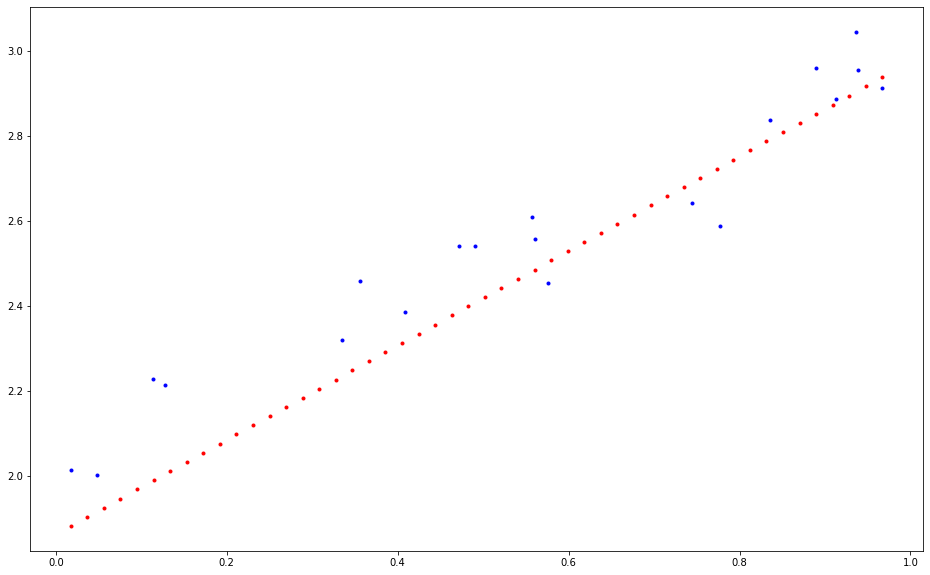

In [36]:
plt.plot(X_train, y_train, 'b.')
X_linear_regression = np.linspace(min(X_train), max(X_train), 50)
plt.plot(X_linear_regression, linear_regression.m * X_linear_regression + linear_regression.b, 'r.')
plt.show()

## Custom training loops

### Example

```python
my_model = MyModel()

def loss(y_pred, y):
    return tf.reduce_mean(tf.square(y_pred - y))

with tf.GradientTape() as tape:
    current_loss = loss(my_model(inputs), outputs)
    grads = tape.gradient(current_loss, my_model.trainable_variables)
```

```python

my_model = MyModel()

loss = tf.keras.losses.MeanSquaredError()

with tf.GradientTape() as tape:
    current_loss = loss(my_model(inputs), outputs)
    grads = tape.gradient(current_loss, my_model.trainable_variables)
```

```python
my_model = MyModel()
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9)

with tf.GradientTape() as tape:
    current_loss = loss(my_model(inputs), outputs)
    grads = tape.gradient(current_loss, my_model.trainable_variables)

optimizer.apply_gradients(zip(grads, my_model.trainable_variables))
```

```python

my_model = MyModel()

loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9)

batch_losses = []

for inputs, outputs in train_ds:
    with tf.GradientTape() as tape:
        current_loss = loss(my_model(inputs), outputs)
        grads = tape.gradient(current_loss, my_model.trainable_variables)
    batch_losses.append(current_loss)
    optimizer.apply_gradients(zip(grads, my_model.trainable_variables)) 
```

```python

my_model = MyModel()

loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9)


epoch_losses = []

for e in range(num_epochs):
    batch_losses = []

    for inputs, outputs in train_ds:
        with tf.GradientTape() as tape:
            current_loss = loss(my_model(inputs), outputs)
            grads = tape.gradient(current_loss, my_model.trainable_variables)
        batch_losses.append(current_loss)
        optimizer.apply_gradients(zip(grads, my_model.trainable_variables)) 
        
    epoch_losses.append(np.mean(batch_losses))
```